In [3]:
import requests
import pandas as pd
import geopandas as gpd

import sys

sys.path.append("../")

# from helper_functions import *
# from loading_data import *
from Code.helper_functions import initial_loading
from Code.algorithms import random_start_hillclimber

POSTGRES password?WelkomCorne!


### Locations per cluster
The first step is to slightly modify the loading of the clusters

In [ ]:
def load_api_data(prnt=False):
    """
    This function loads in information on the current composition of container
    clusters in Amsterdam. It uses the API from data.amsterdam.nl (available at
    'https://api.data.amsterdam.nl/vsd/afvalclusters'). It returns the coordinates,
    amount and volume of different fractions and the address of the clusters. As
    a check, it is determined whether or not the cluster is currently active.
    Returns:
    - df containing coordinates, dict-like amount and volume per fraction and
    address.
    """
    x_coordinates = []
    y_coordinates = []
    aantal = []
    volumes = []
    adresses = []
    buurt = []

    link = 'https://api.data.amsterdam.nl/vsd/afvalclusters'

    while link != None: #This is the case on the last page of the API
        if prnt: # Can be used for some kind of monitoring of progres
            print(link)
        response = requests.get(link)
        output = response.json()
        for result in output['results']:
            if result['cluster_datum_einde_cluster'] == None: #Als het cluster nog actief is
                x_coordinates.append(str(result['cluster_geometrie']['coordinates'][0]))
                y_coordinates.append(str(result['cluster_geometrie']['coordinates'][1]))
                aantal.append(result['cluster_fractie_aantal'])
                volumes.append(result['cluster_fractie_volume'])
                adresses.append(result['bag_adres_openbare_ruimte_naam'])
                buurt.append(result['gbd_buurt_code'])
        try:
            link = output['_links']['next']['href'] #Retrieve link for next page
        except:
            link = None #True for last page of API

    df_clusters = pd.DataFrame([x_coordinates, y_coordinates, aantal, volumes, adresses, buurt]).T
    df_clusters = df_clusters.rename(columns={0: 'cluster_x', 1:'cluster_y', 2:'aantal_per_fractie', 3:'volume_per_fractie', 4: 'street_name', 5:'buurt'})
    # Transform coordinates of clusters to ints, as this helps easing join
    df_clusters['cluster_x'] = df_clusters['cluster_x'].astype('float').round(0).astype('int')
    df_clusters['cluster_y'] = df_clusters['cluster_y'].astype('float').round(0).astype('int')
    df_clusters['wijk'] = df_clusters['buurt'].str[:3]
    df_clusters['stadsdeel'] = df_clusters['buurt'].str[0]
    return df_clusters

In [ ]:
def load_geodata_containers(subsectie=None):
    """
    This function loads in all polygons representing areas in the city of Amsterdam
    where general waste needs to be brought to a container. This is different
    from the alternative where general waste is collected from the sidewalk. This
    is needed to filter the address POI's to relevant POI's for optimization.
    Subsectie is optional parameter to filter on specific stadsdelen. This can be used
    for partial optimization.

    Returns:
    - List of polygons making up the area of centralized garbage collection
    """

    source = gpd.read_file('../data/Inzameling_huisvuil_100220.shp')
    source = source[source['aanbiedwij'] == 'Breng uw restafval  naar een container voor restafval.']
    if subsectie:
        source = source[source['sdcode'] == subsectie]
    return list(source.geometry)

In [ ]:
def get_db_afvalcluster_info():
    """
    Function that modifies loads in data on the garbage clusters from the Postgres
    database and modifies the resulting dataframe in a way that makes it usable
    for future analysis
    Returns:
    - pandas DataFrame containing all information from the database and also the
    added coordinates for the clusters and the type of POI
    """
    polygon_list = load_geodata_containers()
    db_df = get_dataframe("""SELECT *
                             FROM proj_afval_netwerk.afv_rel_nodes_poi
                             """)
    db_df['woning'] = db_df['bk_afv_rel_nodes_poi'].str.split('~')
    db_df['cluster_x'] = db_df['woning'].apply(lambda x: x[0]).astype('float').round(0).astype('int')
    db_df['cluster_y'] = db_df['woning'].apply(lambda x: x[1]).astype('float').round(0).astype('int')
    db_df['type'] = db_df['woning'].apply(lambda x: x[2])
    db_df['bag'] = db_df['woning'].apply(lambda x: x[3])
    print('a')
#     db_df['uses_container'] = db_df.apply(lambda row: address_in_service_area(row['cluster_x'], row['cluster_y'], polygon_list = polygon_list), axis=1)
    db_df = db_df.drop('woning', axis=1)
    return db_df

In [ ]:
def create_all_households(rel_poi_df, subsectie=None):
    """
    Function that creates a dataframe containing all households as rows
    """
    polygon_list = load_geodata_containers(subsectie = subsectie)
    all_households = rel_poi_df[rel_poi_df['type']!='afval_cluster']
    all_households = all_households[['s1_afv_nodes', 'cluster_x', 'cluster_y']]
    print('b')
    all_households['uses_container'] = all_households.apply(lambda row: address_in_service_area(row['cluster_x'], row['cluster_y'], polygon_list=polygon_list), axis=1)
    return all_households

In [ ]:
df_clusters = load_api_data_neigborhood()

In [ ]:
df_clusters['stadsdeel'].value_counts()
# Stadsdeel Zuid-Oost (T) has 423 clusters. This is to be optimized

In [ ]:
rel_poi_df = get_db_afvalcluster_info()

In [ ]:
all_households = create_all_households(rel_poi_df, subsectie='T')

In [ ]:
joined = join_api_db(rel_poi_df, df_clusters)

In [ ]:
joined['rest'], joined['plastic'], joined['papier'], joined['glas'], joined['textiel'], joined['totaal'] = zip(*joined['aantal_per_fractie'].apply(lambda x: containers_per_cluster(x)))

In [ ]:
df_afstandn2 = distance_matrix_with_counts()

In [ ]:
for i in ['T', 'M', 'N', 'A', 'K', 'E', 'F', 'B']:
    print(i)
    all_households, rel_poi_df, joined, df_afstandn2 = initial_loading(use_count=True, subsectie=i)
    joined_cluster_distance, good_result_rich, aansluitingen, avg_distance, penalties = \
    analyze_candidate_solution(joined, all_households, rel_poi_df, df_afstandn2, clean=True, use_count=True)

Do you want to use addresses instead of clusters?True
What stadsdeel do you want to make as a subsection?T
API data loaded
DB relation POIs loaded
Table all households created
API and DB joined
containers per cluster determined


..\Code\loading_data.py:239: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  verblijfsobjecten['bag'] = verblijfsobjecten['split'].apply(lambda x: x[3]).astype('int64')


distance matrix loaded
How many random iterations?10
How many iterations hillclimber?20
Do you want the results saved(True/False)?True
Do you want to only use a subset of data?Ture
Do you want to use addresses instead of clusters?True
What parameter to optimize on (score/penalties)?penalties
Average distance is : 249.6004611676881
Penalties are: 308.1859662117452
Average distance is : 254.02442956940632
Penalties are: 319.9085892115329
Average distance is : 251.95626616743436
Penalties are: 320.9413878810317
Average distance is : 254.4581740794967
Penalties are: 335.33427856672427
Average distance is : 258.37575446499943
Penalties are: 325.6733294122486
Average distance is : 257.2809305525734
Penalties are: 340.44575707527764
Average distance is : 256.8267005819576
Penalties are: 334.76564096816645
Average distance is : 263.8342913062763
Penalties are: 336.82620506334325
Average distance is : 260.2847936184146
Penalties are: 324.4653209068839
Average distance is : 250.34930114917154
Pe

..\Code\algorithms.py:123: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  today = str(pd.datetime.now().date()) + '-' + str(pd.datetime.now().hour)


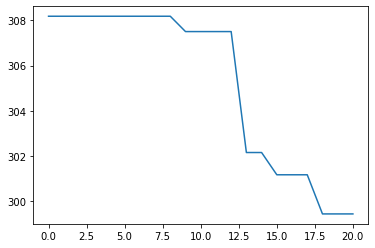

In [4]:
all_households, rel_poi_df, joined, df_afstandn2 = initial_loading()
hill_df, best_solution = random_start_hillclimber(joined, all_households, rel_poi_df, df_afstandn2)

How many random iterations?10
How many iterations hillclimber?5000
Do you want the results saved(True/False)?True
Do you want to only use a subset of data?True
Do you want to use addresses instead of clusters?True
What parameter to optimize on (score/penalties)?penalties
Average distance is : 262.65982991480155
Penalties are: 233.10531889616075
Average distance is : 320.6225024782058
Penalties are: 409.69959180377947
Average distance is : 322.06387659201374
Penalties are: 407.30581466452566
Average distance is : 323.35166086855264
Penalties are: 420.21964303157165
Average distance is : 317.8552178998162
Penalties are: 403.97417537540144
Average distance is : 312.7368666186507
Penalties are: 399.76972616875213
Average distance is : 318.27708434137844
Penalties are: 404.8859799062581
Average distance is : 328.9151957667726
Penalties are: 419.0692936965252
Average distance is : 315.1595438338016
Penalties are: 395.23182397681205
Average distance is : 327.5193960176966
Penalties are: 412.3

Average distance is : 262.72165439763137
Penalties are: 227.5681101546542
227.5681101546542 226.9835252407353
Average distance is : 262.92773268691326
Penalties are: 229.4101287673517
229.4101287673517 226.9835252407353
Average distance is : 266.1212491690049
Penalties are: 242.39756257034472
242.39756257034472 226.9835252407353
Average distance is : 263.75956602292246
Penalties are: 233.82738953270248
233.82738953270248 226.9835252407353
Average distance is : 262.4638083081758
Penalties are: 226.53607628496397
226.53607628496397 226.9835252407353
Average distance is : 263.28595524212733
Penalties are: 231.96029917879028
231.96029917879028 226.53607628496397
Average distance is : 262.83103885014526
Penalties are: 233.61040733053835
233.61040733053835 226.53607628496397
Average distance is : 262.4618613573772
Penalties are: 226.57996571345197
226.57996571345197 226.53607628496397
Average distance is : 261.55724970685145
Penalties are: 236.09877135353702
236.09877135353702 226.5360762849

Average distance is : 262.34921383186725
Penalties are: 230.42949760261232
230.42949760261232 213.49797835966694
Average distance is : 261.824239099217
Penalties are: 223.65151238107376
223.65151238107376 213.49797835966694
Average distance is : 262.1156768822364
Penalties are: 210.81836712113488
210.81836712113488 213.49797835966694
Average distance is : 263.25868305463854
Penalties are: 213.92000917431193
213.92000917431193 210.81836712113488
Average distance is : 261.7716364761783
Penalties are: 220.53432560312606
220.53432560312606 210.81836712113488
Average distance is : 262.0660342381356
Penalties are: 212.0712998640843
212.0712998640843 210.81836712113488
Average distance is : 262.7655185007219
Penalties are: 210.63422020472302
210.63422020472302 210.81836712113488
Average distance is : 267.4580355893809
Penalties are: 218.5099860474006
218.5099860474006 210.63422020472302
Average distance is : 262.86978923684194
Penalties are: 213.38835888124362
213.38835888124362 210.634220204

Average distance is : 263.2625483253971
Penalties are: 212.73648891390218
212.73648891390218 208.14839652975408
Average distance is : 262.9465502134858
Penalties are: 210.5970514590324
210.5970514590324 208.14839652975408
Average distance is : 263.1645653668109
Penalties are: 212.8815814816385
212.8815814816385 208.14839652975408
Average distance is : 264.10896173728764
Penalties are: 212.25337384785286
212.25337384785286 208.14839652975408
Average distance is : 259.38986336141784
Penalties are: 222.83432527715246
222.83432527715246 208.14839652975408
Average distance is : 262.2459008769522
Penalties are: 212.74890298602557
212.74890298602557 208.14839652975408
Average distance is : 262.70146220844885
Penalties are: 214.3653152317037
214.3653152317037 208.14839652975408
Average distance is : 263.2817083471557
Penalties are: 208.13665992014612
208.13665992014612 208.14839652975408
Average distance is : 263.519645894612
Penalties are: 210.0419866627023
210.0419866627023 208.1366599201461

Average distance is : 262.413831546628
Penalties are: 206.98740954080114
206.98740954080114 202.50434399558216
Average distance is : 262.24183073879465
Penalties are: 203.63081086365182
203.63081086365182 202.50434399558216
Average distance is : 263.20120798292066
Penalties are: 204.8107891975702
204.8107891975702 202.50434399558216
Average distance is : 262.7358293911654
Penalties are: 207.85330121914959
207.85330121914959 202.50434399558216
Average distance is : 263.4919459876131
Penalties are: 206.14976579159764
206.14976579159764 202.50434399558216
Average distance is : 262.5781881671038
Penalties are: 215.71683887970235
215.71683887970235 202.50434399558216
Average distance is : 262.6619808231565
Penalties are: 203.77011932373307
203.77011932373307 202.50434399558216
Average distance is : 262.53843226707573
Penalties are: 202.05666537105475
202.05666537105475 202.50434399558216
Average distance is : 263.09952987052003
Penalties are: 206.96364079690753
206.96364079690753 202.056665

Average distance is : 265.26973515529255
Penalties are: 208.2912567085598
208.2912567085598 198.25701734091777
Average distance is : 268.668134131438
Penalties are: 199.3290399668888
199.3290399668888 198.25701734091777
Average distance is : 265.05876336761173
Penalties are: 203.07307863904572
203.07307863904572 198.25701734091777
Average distance is : 265.6388299148602
Penalties are: 208.3975112705353
208.3975112705353 198.25701734091777
Average distance is : 266.30599608252714
Penalties are: 205.1672763124363
205.1672763124363 198.25701734091777
Average distance is : 264.0128831641952
Penalties are: 203.7610673897355
203.7610673897355 198.25701734091777
Average distance is : 265.191130020915
Penalties are: 198.22502048223456
198.22502048223456 198.25701734091777
Average distance is : 260.0482530659429
Penalties are: 226.26367579105974
226.26367579105974 198.22502048223456
Average distance is : 263.85899913487043
Penalties are: 206.90742280426198
206.90742280426198 198.22502048223456


Average distance is : 267.36917003056936
Penalties are: 192.99507925016982
192.99507925016982 193.18360585088317
Average distance is : 267.7805008951551
Penalties are: 200.40636368461276
200.40636368461276 192.99507925016982
Average distance is : 267.402528189252
Penalties are: 192.99886376953125
192.99886376953125 192.99507925016982
Average distance is : 266.9241723604875
Penalties are: 198.16519444208558
198.16519444208558 192.99507925016982
Average distance is : 267.52202608751793
Penalties are: 194.9586221127717
194.9586221127717 192.99507925016982
Average distance is : 266.6461582820895
Penalties are: 201.46030602844405
201.46030602844405 192.99507925016982
Average distance is : 267.74324512403797
Penalties are: 196.17357131029212
196.17357131029212 192.99507925016982
Average distance is : 264.9251433759017
Penalties are: 196.60337086022417
196.60337086022417 192.99507925016982
Average distance is : 268.04336674098477
Penalties are: 197.34194314707878
197.34194314707878 192.995079

Average distance is : 265.72606880929686
Penalties are: 191.5074045091712
191.5074045091712 190.10795013162362
Average distance is : 261.9902925717616
Penalties are: 198.53847802734376
198.53847802734376 190.10795013162362
Average distance is : 266.3492115351576
Penalties are: 191.0782634808084
191.0782634808084 190.10795013162362
Average distance is : 266.45262270401423
Penalties are: 193.54545418648095
193.54545418648095 190.10795013162362
Average distance is : 266.1864205376835
Penalties are: 192.35880388077445
192.35880388077445 190.10795013162362
Average distance is : 266.59704447061625
Penalties are: 197.84730005944297
197.84730005944297 190.10795013162362
Average distance is : 267.58298562802725
Penalties are: 198.42883145805027
198.42883145805027 190.10795013162362
Average distance is : 265.8234516380218
Penalties are: 190.23946694548232
190.23946694548232 190.10795013162362
Average distance is : 266.4374715147424
Penalties are: 191.86124830163044
191.86124830163044 190.1079501

Average distance is : 266.0778422112885
Penalties are: 190.47329497961266
190.47329497961266 185.72271866508154
Average distance is : 266.13745598854797
Penalties are: 191.32103305451767
191.32103305451767 185.72271866508154
Average distance is : 267.02041961199126
Penalties are: 206.7200338828974
206.7200338828974 185.72271866508154
Average distance is : 266.3277041950963
Penalties are: 198.04236953290868
198.04236953290868 185.72271866508154
Average distance is : 265.9943527414264
Penalties are: 195.12647412109374
195.12647412109374 185.72271866508154
Average distance is : 267.10589556586547
Penalties are: 187.00090280254778
187.00090280254778 185.72271866508154
Average distance is : 266.3704390060255
Penalties are: 186.62060776154888
186.62060776154888 185.72271866508154
Average distance is : 266.24705824764266
Penalties are: 187.10512472401496
187.10512472401496 185.72271866508154
Average distance is : 265.6176924351071
Penalties are: 192.77805279806384
192.77805279806384 185.72271

Average distance is : 265.6818181036981
Penalties are: 188.4090040123981
188.4090040123981 184.31514799167795
Average distance is : 266.67975784019035
Penalties are: 198.95349450943954
198.95349450943954 184.31514799167795
Average distance is : 265.506586573141
Penalties are: 187.58802127207878
187.58802127207878 184.31514799167795
Average distance is : 264.7549566719959
Penalties are: 189.79030391490807
189.79030391490807 184.31514799167795
Average distance is : 265.3518974445128
Penalties are: 187.36207154381793
187.36207154381793 184.31514799167795
Average distance is : 266.2899170628518
Penalties are: 187.83234931216032
187.83234931216032 184.31514799167795
Average distance is : 265.8687017887231
Penalties are: 185.7299531986246
185.7299531986246 184.31514799167795
Average distance is : 263.71442397561106
Penalties are: 201.15371567170516
201.15371567170516 184.31514799167795
Average distance is : 261.22085419473365
Penalties are: 190.77586072186838
190.77586072186838 184.315147991

Average distance is : 264.51578939512024
Penalties are: 185.7591649753736
185.7591649753736 182.86536149796194
Average distance is : 265.5695503720308
Penalties are: 185.59472694463315
185.59472694463315 182.86536149796194
Average distance is : 264.4423446898554
Penalties are: 201.0152127184827
201.0152127184827 182.86536149796194
Average distance is : 265.0416147491517
Penalties are: 183.88083225792758
183.88083225792758 182.86536149796194
Average distance is : 265.0716568560913
Penalties are: 184.64469304093072
184.64469304093072 182.86536149796194
Average distance is : 265.3204507330711
Penalties are: 185.04222125509511
185.04222125509511 182.86536149796194
Average distance is : 264.8527995385687
Penalties are: 191.59926982846468
191.59926982846468 182.86536149796194
Average distance is : 264.9651075400924
Penalties are: 184.9883234544837
184.9883234544837 182.86536149796194
Average distance is : 265.17522142836594
Penalties are: 190.1347924592391
190.1347924592391 182.8653614979619

Average distance is : 269.3475552805516
Penalties are: 180.0200532651155
180.0200532651155 178.14625711192255
Average distance is : 267.44237724646257
Penalties are: 178.74924740998642
178.74924740998642 178.14625711192255
Average distance is : 267.11514740294166
Penalties are: 177.91668406080166
177.91668406080166 178.14625711192255
Average distance is : 267.472915192656
Penalties are: 181.91592032523778
181.91592032523778 177.91668406080166
Average distance is : 267.23384081940407
Penalties are: 185.06955056895382
185.06955056895382 177.91668406080166
Average distance is : 266.9519902094205
Penalties are: 180.33042703379755
180.33042703379755 177.91668406080166
Average distance is : 267.337683022066
Penalties are: 178.85648155146058
178.85648155146058 177.91668406080166
Average distance is : 267.13701536982467
Penalties are: 181.54395142663043
181.54395142663043 177.91668406080166
Average distance is : 267.23903104550277
Penalties are: 181.2127445652174
181.2127445652174 177.91668406

Average distance is : 269.97323167434485
Penalties are: 192.32646615998635
192.32646615998635 177.20899053158968
Average distance is : 266.50099395563626
Penalties are: 180.33167936905573
180.33167936905573 177.20899053158968
Average distance is : 268.3736419415115
Penalties are: 190.95413329371308
190.95413329371308 177.20899053158968
Average distance is : 266.2370051713397
Penalties are: 180.21310442849864
180.21310442849864 177.20899053158968
Average distance is : 267.1001052682083
Penalties are: 179.43747010869566
179.43747010869566 177.20899053158968
Average distance is : 267.0762911987137
Penalties are: 176.77995282778534
176.77995282778534 177.20899053158968
Average distance is : 271.48595251540286
Penalties are: 182.03434434442931
182.03434434442931 176.77995282778534
Average distance is : 267.29302692246586
Penalties are: 178.58140858525817
178.58140858525817 176.77995282778534
Average distance is : 267.0019037670426
Penalties are: 178.09987117866848
178.09987117866848 176.779

Average distance is : 265.9759155227487
Penalties are: 180.01616510275136
180.01616510275136 176.05300428838314
Average distance is : 267.75537165126804
Penalties are: 179.77298291015623
179.77298291015623 176.05300428838314
Average distance is : 267.1039947264733
Penalties are: 177.18554566491167
177.18554566491167 176.05300428838314
Average distance is : 268.90005711508235
Penalties are: 188.88971724269697
188.88971724269697 176.05300428838314
Average distance is : 263.38922265298476
Penalties are: 186.13804577105978
186.13804577105978 176.05300428838314
Average distance is : 267.15694755238235
Penalties are: 176.00239578379754
176.00239578379754 176.05300428838314
Average distance is : 267.5620230465957
Penalties are: 199.47196545597285
199.47196545597285 176.00239578379754
Average distance is : 267.16711240975746
Penalties are: 176.44012856657608
176.44012856657608 176.00239578379754
Average distance is : 267.2628481607476
Penalties are: 176.8424156334918
176.8424156334918 176.0023

Average distance is : 266.9846735535653
Penalties are: 181.81228585682743
181.81228585682743 175.00055494225543
Average distance is : 267.1042839924191
Penalties are: 176.21643703294836
176.21643703294836 175.00055494225543
Average distance is : 270.61533317248427
Penalties are: 183.44385487432064
183.44385487432064 175.00055494225543
Average distance is : 267.00026792423085
Penalties are: 176.11370592730975
176.11370592730975 175.00055494225543
Average distance is : 267.71804099621335
Penalties are: 175.86444556725542
175.86444556725542 175.00055494225543
Average distance is : 267.13590706145635
Penalties are: 175.55810827105978
175.55810827105978 175.00055494225543
Average distance is : 266.86612926617454
Penalties are: 175.7300004245924
175.7300004245924 175.00055494225543
Average distance is : 267.121162264943
Penalties are: 174.78496798573372
174.78496798573372 175.00055494225543
Average distance is : 268.34158670573174
Penalties are: 190.93043552564535
190.93043552564535 174.7849

Average distance is : 266.9974072467805
Penalties are: 176.31648055366847
176.31648055366847 171.89717790421196
Average distance is : 268.0844545960479
Penalties are: 174.6871769913383
174.6871769913383 171.89717790421196
Average distance is : 268.035303414211
Penalties are: 174.41803957201085
174.41803957201085 171.89717790421196
Average distance is : 267.0259900619438
Penalties are: 179.24436555281926
179.24436555281926 171.89717790421196
Average distance is : 267.2203713635196
Penalties are: 171.55953918987768
171.55953918987768 171.89717790421196
Average distance is : 267.8640912872086
Penalties are: 173.99760814368204
173.99760814368204 171.55953918987768
Average distance is : 263.7215518460155
Penalties are: 183.11754938009508
183.11754938009508 171.55953918987768
Average distance is : 266.0132602235851
Penalties are: 171.370920653789
171.370920653789 171.55953918987768
Average distance is : 265.8564611066603
Penalties are: 173.96973721078328
173.96973721078328 171.370920653789
A

Average distance is : 266.1203229815078
Penalties are: 170.15953256208874
170.15953256208874 169.16448129908727
Average distance is : 260.015575335977
Penalties are: 183.66322613033324
183.66322613033324 169.16448129908727
Average distance is : 266.71219411713116
Penalties are: 172.73659583545592
172.73659583545592 169.16448129908727
Average distance is : 266.0383071294839
Penalties are: 170.4565805349183
170.4565805349183 169.16448129908727
Average distance is : 272.3330434483678
Penalties are: 178.1277864996816
178.1277864996816 169.16448129908727
Average distance is : 266.6039273237678
Penalties are: 175.7357773721078
175.7357773721078 169.16448129908727
Average distance is : 265.4593420361579
Penalties are: 169.33002774357885
169.33002774357885 169.16448129908727
Average distance is : 265.88988908712724
Penalties are: 172.49230645298238
172.49230645298238 169.16448129908727
Average distance is : 265.8950778829656
Penalties are: 169.16762992995118
169.16762992995118 169.164481299087

Average distance is : 263.2101214241323
Penalties are: 178.0676548928041
178.0676548928041 165.9872279346211
Average distance is : 262.8315259533899
Penalties are: 175.83386529399274
175.83386529399274 165.9872279346211
Average distance is : 263.07501449704677
Penalties are: 167.86787548291232
167.86787548291232 165.9872279346211
Average distance is : 263.1609326381498
Penalties are: 167.9176437274464
167.9176437274464 165.9872279346211
Average distance is : 262.2482681868553
Penalties are: 173.00759974527702
173.00759974527702 165.9872279346211
Average distance is : 262.8766093943644
Penalties are: 170.04534268732752
170.04534268732752 165.9872279346211
Average distance is : 262.82205625642735
Penalties are: 165.9872279346211
165.9872279346211 165.9872279346211
Average distance is : 262.9468098657179
Penalties are: 167.63663288049247
167.63663288049247 165.9872279346211
Average distance is : 263.07970279220393
Penalties are: 168.3938342390151
168.3938342390151 165.9872279346211
Averag

Average distance is : 264.5303617769836
Penalties are: 180.01821855232433
180.01821855232433 164.71137879431117
Average distance is : 264.9646060792379
Penalties are: 168.522066249204
168.522066249204 164.71137879431117
Average distance is : 261.90540731128397
Penalties are: 170.3029825514753
170.3029825514753 164.71137879431117
Average distance is : 267.16415777533837
Penalties are: 174.3569728932286
174.3569728932286 164.71137879431117
Average distance is : 263.55534971946093
Penalties are: 173.02957643812354
173.02957643812354 164.71137879431117
Average distance is : 263.0799173061946
Penalties are: 172.07253631925283
172.07253631925283 164.71137879431117
Average distance is : 264.80032374832325
Penalties are: 169.95594875822542
169.95594875822542 164.71137879431117
Average distance is : 264.41727301362084
Penalties are: 175.83722095096581
175.83722095096581 164.71137879431117
Average distance is : 263.4060699041611
Penalties are: 168.1975562513267
168.1975562513267 164.711378794311

Average distance is : 262.3252267198727
Penalties are: 176.38893394183822
176.38893394183822 161.34420271704522
Average distance is : 262.37290239114367
Penalties are: 159.5606908087455
159.5606908087455 161.34420271704522
Average distance is : 261.81177632559564
Penalties are: 166.47425707917637
166.47425707917637 159.5606908087455
Average distance is : 262.29448526607143
Penalties are: 165.19733948206326
165.19733948206326 159.5606908087455
Average distance is : 262.3929363516868
Penalties are: 160.2498252175759
160.2498252175759 159.5606908087455
Average distance is : 261.41784707541325
Penalties are: 164.98526542135428
164.98526542135428 159.5606908087455
Average distance is : 263.29153761607245
Penalties are: 162.62119263426027
162.62119263426027 159.5606908087455
Average distance is : 261.8883084632499
Penalties are: 160.8865034812142
160.8865034812142 159.5606908087455
Average distance is : 263.5417644182801
Penalties are: 166.09751056876058
166.09751056876058 159.5606908087455


Average distance is : 261.45664120883407
Penalties are: 165.9789371683294
165.9789371683294 157.83040711101677
Average distance is : 262.2126507599317
Penalties are: 162.63040180428783
162.63040180428783 157.83040711101677
Average distance is : 263.1275570412712
Penalties are: 158.93164992570578
158.93164992570578 157.83040711101677
Average distance is : 262.4450708671867
Penalties are: 157.83889819571218
157.83889819571218 157.83040711101677
Average distance is : 262.25008838002725
Penalties are: 159.78967251114415
159.78967251114415 157.83040711101677
Average distance is : 262.9612774315526
Penalties are: 163.7484708766716
163.7484708766716 157.83040711101677
Average distance is : 261.8789892259136
Penalties are: 165.2073654425812
165.2073654425812 157.83040711101677
Average distance is : 262.5479535001946
Penalties are: 160.31387321163234
160.31387321163234 157.83040711101677
Average distance is : 263.51940323133675
Penalties are: 167.27641999915096
167.27641999915096 157.8304071110

Average distance is : 260.74586143193994
Penalties are: 169.93473455420678
169.93473455420678 157.34228889832306
Average distance is : 261.4147418465984
Penalties are: 174.69879063893012
174.69879063893012 157.34228889832306
Average distance is : 262.0611301142095
Penalties are: 173.9627469467717
173.9627469467717 157.34228889832306
Average distance is : 260.9020828437533
Penalties are: 157.27540356612184
157.27540356612184 157.34228889832306
Average distance is : 260.4537818078147
Penalties are: 160.29321840373592
160.29321840373592 157.27540356612184
Average distance is : 259.79417317033824
Penalties are: 168.58063026958183
168.58063026958183 157.27540356612184
Average distance is : 261.1377756456794
Penalties are: 160.1525128635109
160.1525128635109 157.27540356612184
Average distance is : 259.1646208308985
Penalties are: 161.32437911271495
161.32437911271495 157.27540356612184
Average distance is : 262.7124382113402
Penalties are: 161.12618463171302
161.12618463171302 157.275403566

Average distance is : 260.7759499967932
Penalties are: 164.2153281893441
164.2153281893441 155.78423029080872
Average distance is : 261.2312022096119
Penalties are: 158.79634241137762
158.79634241137762 155.78423029080872
Average distance is : 266.4984565870024
Penalties are: 160.05835344937378
160.05835344937378 155.78423029080872
Average distance is : 261.95955668221205
Penalties are: 158.1598784334536
158.1598784334536 155.78423029080872
Average distance is : 260.6200179653823
Penalties are: 170.20319078751857
170.20319078751857 155.78423029080872
Average distance is : 260.0158992128387
Penalties are: 158.98408244534068
158.98408244534068 155.78423029080872
Average distance is : 260.4861588194223
Penalties are: 161.40137985993212
161.40137985993212 155.78423029080872
Average distance is : 260.5373393025899
Penalties are: 155.09481558055612
155.09481558055612 155.78423029080872
Average distance is : 261.2835468656182
Penalties are: 164.88608038632984
164.88608038632984 155.0948155805

Average distance is : 261.644050767312
Penalties are: 157.83101575170892
157.83101575170892 154.1650211862608
Average distance is : 261.5563431169092
Penalties are: 163.43493593172843
163.43493593172843 154.1650211862608
Average distance is : 261.59066164770275
Penalties are: 154.17223742198445
154.17223742198445 154.1650211862608
Average distance is : 261.8196480187324
Penalties are: 161.8829786651382
161.8829786651382 154.1650211862608
Average distance is : 259.93192869331057
Penalties are: 157.08906151299036
157.08906151299036 154.1650211862608
Average distance is : 261.2599846542193
Penalties are: 161.03118912665053
161.03118912665053 154.1650211862608
Average distance is : 262.3283163536638
Penalties are: 166.68914416422535
166.68914416422535 154.1650211862608
Average distance is : 261.90858745610313
Penalties are: 163.76610737485672
163.76610737485672 154.1650211862608
Average distance is : 262.3435970431204
Penalties are: 164.88463238228678
164.88463238228678 154.1650211862608
A

Average distance is : 267.67671458891704
Penalties are: 157.27705780579967
157.27705780579967 153.22068551776843
Average distance is : 261.87978351698086
Penalties are: 159.2436835010402
159.2436835010402 153.22068551776843
Average distance is : 263.05852958307173
Penalties are: 158.1916214919543
158.1916214919543 153.22068551776843
Average distance is : 261.39968005258237
Penalties are: 159.77904761804203
159.77904761804203 153.22068551776843
Average distance is : 262.3791243041457
Penalties are: 155.11527875429883
155.11527875429883 153.22068551776843
Average distance is : 261.43821677476296
Penalties are: 155.97070538784868
155.97070538784868 153.22068551776843
Average distance is : 262.04062861492844
Penalties are: 155.23179070606716
155.23179070606716 153.22068551776843
Average distance is : 261.47355372880554
Penalties are: 152.62296822060884
152.62296822060884 153.22068551776843
Average distance is : 261.51578417694157
Penalties are: 153.22224663524815
153.22224663524815 152.622

Average distance is : 261.42977779287924
Penalties are: 162.38866276058252
162.38866276058252 152.62296822060884
Average distance is : 262.00840319219253
Penalties are: 154.11892217551903
154.11892217551903 152.62296822060884
Average distance is : 261.48963112950685
Penalties are: 160.83291576444614
160.83291576444614 152.62296822060884
Average distance is : 261.0207192556466
Penalties are: 157.23754827410517
157.23754827410517 152.62296822060884
Average distance is : 262.5366709678935
Penalties are: 156.6254986838195
156.6254986838195 152.62296822060884
Average distance is : 261.4381621647216
Penalties are: 154.41476750307817
154.41476750307817 152.62296822060884
Average distance is : 261.91091526887635
Penalties are: 154.21108510593132
154.21108510593132 152.62296822060884
Average distance is : 261.5614020183451
Penalties are: 153.4039823164777
153.4039823164777 152.62296822060884
Average distance is : 261.59950406267245
Penalties are: 156.3316690442831
156.3316690442831 152.62296822

Average distance is : 261.3814167965353
Penalties are: 155.5320740245404
155.5320740245404 152.31645236275634
Average distance is : 262.3464167084839
Penalties are: 153.41702377616437
153.41702377616437 152.31645236275634
Average distance is : 261.7860000632418
Penalties are: 156.9203687216066
156.9203687216066 152.31645236275634
Average distance is : 264.25424454316453
Penalties are: 170.22091836561333
170.22091836561333 152.31645236275634
Average distance is : 261.43251512926776
Penalties are: 155.3956856026833
155.3956856026833 152.31645236275634
Average distance is : 261.079268029887
Penalties are: 152.91121710610113
152.91121710610113 152.31645236275634
Average distance is : 261.390694083143
Penalties are: 161.63429081221076
161.63429081221076 152.31645236275634
Average distance is : 262.26979724054115
Penalties are: 156.03120509064664
156.03120509064664 152.31645236275634
Average distance is : 261.72718593314346
Penalties are: 159.14902768224854
159.14902768224854 152.31645236275

Average distance is : 260.6810476679899
Penalties are: 148.4849036003906
148.4849036003906 148.26034103935805
Average distance is : 261.3522041405815
Penalties are: 154.56375650660215
154.56375650660215 148.26034103935805
Average distance is : 260.8935020078102
Penalties are: 150.08304706406827
150.08304706406827 148.26034103935805
Average distance is : 259.348120057781
Penalties are: 150.63093760879718
150.63093760879718 148.26034103935805
Average distance is : 260.58181344490924
Penalties are: 150.8721716341867
150.8721716341867 148.26034103935805
Average distance is : 260.96613344605225
Penalties are: 154.5091075871439
154.5091075871439 148.26034103935805
Average distance is : 260.4555416071293
Penalties are: 172.38977181637878
172.38977181637878 148.26034103935805
Average distance is : 260.69384560154185
Penalties are: 151.20487061096253
151.20487061096253 148.26034103935805
Average distance is : 260.51186970756163
Penalties are: 150.43513541799345
150.43513541799345 148.2603410393

Average distance is : 261.76190381364876
Penalties are: 146.60915511824396
146.60915511824396 145.92510278945355
Average distance is : 261.9754175744952
Penalties are: 145.76854366747335
145.76854366747335 145.92510278945355
Average distance is : 262.0183000049057
Penalties are: 151.42669341485163
151.42669341485163 145.76854366747335
Average distance is : 264.1145121113139
Penalties are: 171.83105169192882
171.83105169192882 145.76854366747335
Average distance is : 260.8378391850754
Penalties are: 159.47804750987135
159.47804750987135 145.76854366747335
Average distance is : 262.0557811307802
Penalties are: 151.58303908207023
151.58303908207023 145.76854366747335
Average distance is : 262.3157421767881
Penalties are: 146.2487044962425
146.2487044962425 145.76854366747335
Average distance is : 258.31581819809185
Penalties are: 152.24078212966504
152.24078212966504 145.76854366747335
Average distance is : 263.8644392378232
Penalties are: 151.8498015963996
151.8498015963996 145.768543667

Average distance is : 263.3572383141702
Penalties are: 146.65401659944808
146.65401659944808 144.08942438972616
Average distance is : 261.8768451761128
Penalties are: 150.03748176607937
150.03748176607937 144.08942438972616
Average distance is : 262.15600424692707
Penalties are: 148.2431831670558
148.2431831670558 144.08942438972616
Average distance is : 261.833362026798
Penalties are: 144.05139176395667
144.05139176395667 144.08942438972616
Average distance is : 268.06748076243974
Penalties are: 153.0216591381872
153.0216591381872 144.05139176395667
Average distance is : 261.59934430662395
Penalties are: 145.4532519422628
145.4532519422628 144.05139176395667
Average distance is : 261.833362026798
Penalties are: 144.73914383358095
144.73914383358095 144.05139176395667
Average distance is : 261.58287184809416
Penalties are: 149.3620813203142
149.3620813203142 144.05139176395667
Average distance is : 261.2635500917138
Penalties are: 145.7757490341753
145.7757490341753 144.05139176395667


Average distance is : 261.38095263140787
Penalties are: 146.0473025684568
146.0473025684568 142.83065470176183
Average distance is : 261.39706583617965
Penalties are: 144.7251271492252
144.7251271492252 142.83065470176183
Average distance is : 262.7436628776567
Penalties are: 147.79715599121178
147.79715599121178 142.83065470176183
Average distance is : 261.7229038806209
Penalties are: 143.9954865209085
143.9954865209085 142.83065470176183
Average distance is : 261.4124047576629
Penalties are: 152.57583029080874
152.57583029080874 142.83065470176183
Average distance is : 262.68104167309366
Penalties are: 156.4733962362454
156.4733962362454 142.83065470176183
Average distance is : 262.14438278838156
Penalties are: 145.80296593080027
145.80296593080027 142.83065470176183
Average distance is : 262.80644619506506
Penalties are: 146.38673277435788
146.38673277435788 142.83065470176183
Average distance is : 261.18523753947716
Penalties are: 147.0605063468478
147.0605063468478 142.83065470176

Average distance is : 262.2920344298445
Penalties are: 140.20737304181702
140.20737304181702 140.947547611972
Average distance is : 264.0250192180441
Penalties are: 152.51609644648474
152.51609644648474 140.20737304181702
Average distance is : 261.46932297136254
Penalties are: 150.39369203498492
150.39369203498492 140.20737304181702
Average distance is : 262.3309138369555
Penalties are: 140.45098365527488
140.45098365527488 140.20737304181702
Average distance is : 263.7667925913451
Penalties are: 142.77474650817234
142.77474650817234 140.20737304181702
Average distance is : 256.8285463771805
Penalties are: 149.8151127149225
149.8151127149225 140.20737304181702
Average distance is : 267.577691272269
Penalties are: 143.2770960730206
143.2770960730206 140.20737304181702
Average distance is : 261.6872398158319
Penalties are: 141.71728064105284
141.71728064105284 140.20737304181702
Average distance is : 263.5377557332305
Penalties are: 156.32018155381022
156.32018155381022 140.2073730418170

Average distance is : 261.61389195706994
Penalties are: 142.2827978773084
142.2827978773084 139.5779383570367
Average distance is : 261.73564614881303
Penalties are: 139.79175831033749
139.79175831033749 139.5779383570367
Average distance is : 262.5077880425384
Penalties are: 144.32006083634045
144.32006083634045 139.5779383570367
Average distance is : 261.60547110415064
Penalties are: 150.5332599235831
150.5332599235831 139.5779383570367
Average distance is : 260.98316287908244
Penalties are: 146.86845811929527
146.86845811929527 139.5779383570367
Average distance is : 262.7144063494672
Penalties are: 136.81756809305483
136.81756809305483 139.5779383570367
Average distance is : 263.61468249126875
Penalties are: 142.48346603837663
142.48346603837663 136.81756809305483
Average distance is : 261.85438740520715
Penalties are: 145.7789065843097
145.7789065843097 136.81756809305483
Average distance is : 262.7144063494672
Penalties are: 138.94016955340464
138.94016955340464 136.8175680930548

Average distance is : 263.1314126194919
Penalties are: 144.27239091951094
144.27239091951094 135.41582286890812
Average distance is : 263.8441351675074
Penalties are: 148.81450286575526
148.81450286575526 135.41582286890812
Average distance is : 263.53820280898947
Penalties are: 136.28334935897436
136.28334935897436 135.41582286890812
Average distance is : 259.1728075863607
Penalties are: 146.53180425369334
146.53180425369334 135.41582286890812
Average distance is : 264.62639225502113
Penalties are: 145.55186865342162
145.55186865342162 135.41582286890812
Average distance is : 263.1627316391207
Penalties are: 139.877257757779
139.877257757779 135.41582286890812
Average distance is : 262.8970848076259
Penalties are: 135.31111839870945
135.31111839870945 135.41582286890812
Average distance is : 265.1642107667563
Penalties are: 135.62038661063
135.62038661063 135.31111839870945
Average distance is : 265.1707517959796
Penalties are: 145.07730325607065
145.07730325607065 135.31111839870945


Average distance is : 262.49083091776777
Penalties are: 136.6213913228052
136.6213913228052 133.73824575479708
Average distance is : 264.1898682122625
Penalties are: 137.32873401681098
137.32873401681098 133.73824575479708
Average distance is : 263.22947505328744
Penalties are: 136.184251464595
136.184251464595 133.73824575479708
Average distance is : 261.5764120413586
Penalties are: 143.25778827050434
143.25778827050434 133.73824575479708
Average distance is : 263.35519359740636
Penalties are: 134.35177542876548
134.35177542876548 133.73824575479708
Average distance is : 263.3159084674157
Penalties are: 135.01753672100523
135.01753672100523 133.73824575479708
Average distance is : 263.65287957257345
Penalties are: 143.62537485141786
143.62537485141786 133.73824575479708
Average distance is : 263.8270984857527
Penalties are: 139.33159085117228
139.33159085117228 133.73824575479708
Average distance is : 268.80984501374456
Penalties are: 135.80397304296145
135.80397304296145 133.73824575

Average distance is : 261.93728734553696
Penalties are: 136.46947934708777
136.46947934708777 131.467229686704
Average distance is : 262.15641892482813
Penalties are: 131.76979790711496
131.76979790711496 131.467229686704
Average distance is : 263.36691677027795
Penalties are: 140.65481764730856
140.65481764730856 131.467229686704
Average distance is : 262.99695724370787
Penalties are: 133.51726449736796
133.51726449736796 131.467229686704
Average distance is : 262.3257247916843
Penalties are: 137.41466167855324
137.41466167855324 131.467229686704
Average distance is : 256.4739203443343
Penalties are: 147.5109411827135
147.5109411827135 131.467229686704
Average distance is : 262.62548703154215
Penalties are: 137.64382830941665
137.64382830941665 131.467229686704
Average distance is : 261.48552671390223
Penalties are: 152.60567651717238
152.60567651717238 131.467229686704
Average distance is : 262.2177096152472
Penalties are: 133.76360861351674
133.76360861351674 131.467229686704
Averag

Average distance is : 261.0473133596462
Penalties are: 141.751804495479
141.751804495479 128.99445457632874
Average distance is : 261.1847255520761
Penalties are: 131.08269808116827
131.08269808116827 128.99445457632874
Average distance is : 261.67788400479714
Penalties are: 132.15995875785362
132.15995875785362 128.99445457632874
Average distance is : 261.3659057608974
Penalties are: 136.2376171463746
136.2376171463746 128.99445457632874
Average distance is : 261.1971781514106
Penalties are: 130.9177419128884
130.9177419128884 128.99445457632874
Average distance is : 261.0067321235334
Penalties are: 143.2728607785702
143.2728607785702 128.99445457632874
Average distance is : 261.29255386795387
Penalties are: 133.3259690312447
133.3259690312447 128.99445457632874
Average distance is : 261.6267249728919
Penalties are: 132.5807186677422
132.5807186677422 128.99445457632874
Average distance is : 257.0738942332423
Penalties are: 145.91896389454917
145.91896389454917 128.99445457632874
Aver

Average distance is : 262.4350969849576
Penalties are: 129.47794080064526
129.47794080064526 128.22778444982168
Average distance is : 262.52336106693105
Penalties are: 129.75381766853454
129.75381766853454 128.22778444982168
Average distance is : 262.1510683050792
Penalties are: 145.7205473976906
145.7205473976906 128.22778444982168
Average distance is : 261.46053036067144
Penalties are: 129.38872111139412
129.38872111139412 128.22778444982168
Average distance is : 262.3359497679879
Penalties are: 130.92381809305485
130.92381809305485 128.22778444982168
Average distance is : 262.27006309777914
Penalties are: 129.29218419935472
129.29218419935472 128.22778444982168
Average distance is : 261.4868816632563
Penalties are: 130.4680139879436
130.4680139879436 128.22778444982168
Average distance is : 262.4400630902274
Penalties are: 130.91541373747665
130.91541373747665 128.22778444982168
Average distance is : 262.3307774708586
Penalties are: 130.3573192604856
130.3573192604856 128.2277844498

Average distance is : 262.1099790631746
Penalties are: 131.5388176260825
131.5388176260825 123.94881548225506
Average distance is : 261.9311226148132
Penalties are: 126.86673673374088
126.86673673374088 123.94881548225506
Average distance is : 262.3903535474908
Penalties are: 135.52520160468669
135.52520160468669 123.94881548225506
Average distance is : 262.3611374845039
Penalties are: 133.56042288588895
133.56042288588895 123.94881548225506
Average distance is : 261.409734776601
Penalties are: 131.17281372049584
131.17281372049584 123.94881548225506
Average distance is : 262.9128938972932
Penalties are: 127.30656737137036
127.30656737137036 123.94881548225506
Average distance is : 261.87069560156135
Penalties are: 126.7206491127526
126.7206491127526 123.94881548225506
Average distance is : 260.8792490074389
Penalties are: 131.63734150534896
131.63734150534896 123.94881548225506
Average distance is : 256.3994847147267
Penalties are: 132.25807443963322
132.25807443963322 123.94881548225

Average distance is : 260.96590931111837
Penalties are: 127.87439554678215
127.87439554678215 123.26938554932927
Average distance is : 261.9180665158936
Penalties are: 129.51441392851078
129.51441392851078 123.26938554932927
Average distance is : 261.09711256119886
Penalties are: 131.29632322975039
131.29632322975039 123.26938554932927
Average distance is : 261.4555419393596
Penalties are: 124.43861704024454
124.43861704024454 123.26938554932927
Average distance is : 262.91293674459075
Penalties are: 129.6657742613347
129.6657742613347 123.26938554932927
Average distance is : 261.58297810394936
Penalties are: 128.12819803871625
128.12819803871625 123.26938554932927
Average distance is : 261.9167751155043
Penalties are: 124.10578031074886
124.10578031074886 123.26938554932927
Average distance is : 262.2903831860605
Penalties are: 124.48268920869417
124.48268920869417 123.26938554932927
Average distance is : 260.21123984590355
Penalties are: 128.2575113346918
128.2575113346918 123.269385

Average distance is : 261.6117803980484
Penalties are: 126.86987275004242
126.86987275004242 122.79767708863983
Average distance is : 260.9207119152162
Penalties are: 126.98200925454236
126.98200925454236 122.79767708863983
Average distance is : 261.07845244027726
Penalties are: 123.66521939208695
123.66521939208695 122.79767708863983
Average distance is : 261.6980386431054
Penalties are: 124.04984350059433
124.04984350059433 122.79767708863983
Average distance is : 261.2598802432526
Penalties are: 129.80390342163355
129.80390342163355 122.79767708863983
Average distance is : 261.4411110306161
Penalties are: 123.28640051366955
123.28640051366955 122.79767708863983
Average distance is : 260.8194773949221
Penalties are: 124.9900144124639
124.9900144124639 122.79767708863983
Average distance is : 261.5451530527344
Penalties are: 125.47795137120053
125.47795137120053 122.79767708863983
Average distance is : 261.3799776915558
Penalties are: 124.12437508490406
124.12437508490406 122.79767708

Average distance is : 258.00153703991043
Penalties are: 131.1305986627043
131.1305986627043 122.36715935045636
Average distance is : 261.5807324446471
Penalties are: 122.47735132668222
122.47735132668222 122.36715935045636
Average distance is : 260.5041677670698
Penalties are: 132.3634061322729
132.3634061322729 122.36715935045636
Average distance is : 261.5577331124649
Penalties are: 122.53930853322011
122.53930853322011 122.36715935045636
Average distance is : 259.25552700305
Penalties are: 129.23545608151133
129.23545608151133 122.36715935045636
Average distance is : 261.0782528972198
Penalties are: 127.22670074294204
127.22670074294204 122.36715935045636
Average distance is : 260.63449368343646
Penalties are: 122.94292262789214
122.94292262789214 122.36715935045636
Average distance is : 262.03718069973826
Penalties are: 126.74557480365101
126.74557480365101 122.36715935045636
Average distance is : 261.82947942085536
Penalties are: 131.05556179155167
131.05556179155167 122.367159350

Average distance is : 261.74089739600856
Penalties are: 130.4420023349607
130.4420023349607 121.74952795584802
Average distance is : 257.1003443661698
Penalties are: 131.9010566546381
131.9010566546381 121.74952795584802
Average distance is : 262.0333333036947
Penalties are: 124.35288165994483
124.35288165994483 121.74952795584802
Average distance is : 261.6018283527071
Penalties are: 125.19876661006155
125.19876661006155 121.74952795584802
Average distance is : 262.4245752225812
Penalties are: 126.59595739758014
126.59595739758014 121.74952795584802
Average distance is : 261.4473077455198
Penalties are: 123.05325001061344
123.05325001061344 121.74952795584802
Average distance is : 260.2389825149619
Penalties are: 126.59036948584043
126.59036948584043 121.74952795584802
Average distance is : 262.0399160806336
Penalties are: 124.52241018891955
124.52241018891955 121.74952795584802
Average distance is : 261.06678975894744
Penalties are: 124.75295960517937
124.75295960517937 121.749527955

Average distance is : 260.5155991113557
Penalties are: 126.30714032182738
126.30714032182738 121.74952795584802
Average distance is : 260.9570438809709
Penalties are: 121.70206022075992
121.70206022075992 121.74952795584802
Average distance is : 261.95902729455895
Penalties are: 121.83598433453619
121.83598433453619 121.70206022075992
Average distance is : 261.6862091253464
Penalties are: 123.4394442793462
123.4394442793462 121.70206022075992
Average distance is : 266.34946278924053
Penalties are: 147.40637612537512
147.40637612537512 121.70206022075992
Average distance is : 261.84364263235454
Penalties are: 141.15014773933345
141.15014773933345 121.70206022075992
Average distance is : 261.1767075279334
Penalties are: 126.43843772022925
126.43843772022925 121.70206022075992
Average distance is : 261.9906617562076
Penalties are: 130.67272288261515
130.67272288261515 121.70206022075992
Average distance is : 260.26118675527607
Penalties are: 126.49597138611757
126.49597138611757 121.70206

Average distance is : 260.7750543267542
Penalties are: 130.2895760984929
130.2895760984929 121.31779116960307
Average distance is : 260.94314746811
Penalties are: 129.22828396450709
129.22828396450709 121.31779116960307
Average distance is : 260.58336912549396
Penalties are: 124.88824442793462
124.88824442793462 121.31779116960307
Average distance is : 261.1999930356965
Penalties are: 122.8910039057525
122.8910039057525 121.31779116960307
Average distance is : 259.72169359591743
Penalties are: 123.83833653152196
123.83833653152196 121.31779116960307
Average distance is : 260.57538142981974
Penalties are: 125.30054926767141
125.30054926767141 121.31779116960307
Average distance is : 261.10459099924066
Penalties are: 135.45630626194014
135.45630626194014 121.31779116960307
Average distance is : 260.32543117468634
Penalties are: 122.83838853746549
122.83838853746549 121.31779116960307
Average distance is : 260.35360372211903
Penalties are: 123.104537529187
123.104537529187 121.31779116960

Average distance is : 258.8720179198951
Penalties are: 120.04136648270004
120.04136648270004 119.26083600084907
Average distance is : 260.87475600906254
Penalties are: 126.6152971934443
126.6152971934443 119.26083600084907
Average distance is : 260.87624659216334
Penalties are: 120.06302152409255
120.06302152409255 119.26083600084907
Average distance is : 260.520220484838
Penalties are: 120.03168762470814
120.03168762470814 119.26083600084907
Average distance is : 260.72762536896283
Penalties are: 124.20004521333051
124.20004521333051 119.26083600084907
Average distance is : 260.6799975812954
Penalties are: 124.52303810231375
124.52303810231375 119.26083600084907
Average distance is : 260.4774217034704
Penalties are: 119.13660144343027
119.13660144343027 119.26083600084907
Average distance is : 260.9907126627804
Penalties are: 138.28476435000422
138.28476435000422 119.13660144343027
Average distance is : 260.82890008462056
Penalties are: 126.87644570154954
126.87644570154954 119.136601

Average distance is : 260.2986812824574
Penalties are: 134.0289433453619
134.0289433453619 115.13294268732751
Average distance is : 261.61478773653755
Penalties are: 133.4074791536507
133.4074791536507 115.13294268732751
Average distance is : 260.7178150335072
Penalties are: 122.2377772022925
122.2377772022925 115.13294268732751
Average distance is : 260.30258745654845
Penalties are: 117.38650019104223
117.38650019104223 115.13294268732751
Average distance is : 255.83419846317958
Penalties are: 128.26552746646288
128.26552746646288 115.13294268732751
Average distance is : 260.28329735091575
Penalties are: 114.83769330531499
114.83769330531499 115.13294268732751
Average distance is : 259.03087069892507
Penalties are: 120.25340781541858
120.25340781541858 114.83769330531499
Average distance is : 264.12292531108454
Penalties are: 122.04750585838002
122.04750585838002 114.83769330531499
Average distance is : 256.2742141803974
Penalties are: 124.11123838936999
124.11123838936999 114.8376933

Average distance is : 260.56389945118354
Penalties are: 109.79740439803024
109.79740439803024 107.46725050942433
Average distance is : 261.5131360530747
Penalties are: 112.8664463618611
112.8664463618611 107.46725050942433
Average distance is : 260.4062614916526
Penalties are: 119.69558715401598
119.69558715401598 107.46725050942433
Average distance is : 260.94802769463337
Penalties are: 108.96068880539988
108.96068880539988 107.46725050942433
Average distance is : 261.0805784866724
Penalties are: 111.06568566394972
111.06568566394972 107.46725050942433
Average distance is : 257.3217352345685
Penalties are: 125.16170765410084
125.16170765410084 107.46725050942433
Average distance is : 260.64225524077
Penalties are: 114.23937831125826
114.23937831125826 107.46725050942433
Average distance is : 260.6454271758591
Penalties are: 109.57293523942944
109.57293523942944 107.46725050942433
Average distance is : 260.16159803958885
Penalties are: 112.02856807182884
112.02856807182884 107.46725050

Average distance is : 262.6313282218338
Penalties are: 118.06491473362223
118.06491473362223 106.3869647378707
Average distance is : 263.73257863394053
Penalties are: 119.51401548343188
119.51401548343188 106.3869647378707
Average distance is : 261.7942591082834
Penalties are: 112.3504519712805
112.3504519712805 106.3869647378707
Average distance is : 262.4234453381855
Penalties are: 112.27361489931174
112.27361489931174 106.3869647378707
Average distance is : 263.3917054872775
Penalties are: 112.43622962868554
112.43622962868554 106.3869647378707
Average distance is : 262.8717422923297
Penalties are: 107.22054301554932
107.22054301554932 106.3869647378707
Average distance is : 263.2326947437848
Penalties are: 117.47613362782992
117.47613362782992 106.3869647378707
Average distance is : 263.739799376642
Penalties are: 122.76903342641602
122.76903342641602 106.3869647378707
Average distance is : 262.5387285186987
Penalties are: 108.32360216698532
108.32360216698532 106.3869647378707
Ave

Average distance is : 262.516160814811
Penalties are: 111.93532770413799
111.93532770413799 105.47300626646276
Average distance is : 258.2076430576409
Penalties are: 130.50990984588688
130.50990984588688 105.47300626646276
Average distance is : 262.699881691238
Penalties are: 107.82581910102813
107.82581910102813 105.47300626646276
Average distance is : 261.8858084734158
Penalties are: 105.17561481434278
105.17561481434278 105.47300626646276
Average distance is : 262.01601939774025
Penalties are: 118.33083388905096
118.33083388905096 105.17561481434278
Average distance is : 262.4814632460198
Penalties are: 108.38460321607614
108.38460321607614 105.17561481434278
Average distance is : 261.15316071895484
Penalties are: 107.28337001232312
107.28337001232312 105.17561481434278
Average distance is : 261.8925631253901
Penalties are: 106.8689652476846
106.8689652476846 105.17561481434278
Average distance is : 259.2832032432119
Penalties are: 108.59837949273515
108.59837949273515 105.175614814

Average distance is : 262.16442028337667
Penalties are: 109.08818333404139
109.08818333404139 105.11165652746506
Average distance is : 262.4971752098323
Penalties are: 117.45515355367687
117.45515355367687 105.11165652746506
Average distance is : 262.53004501758704
Penalties are: 108.2406426841703
108.2406426841703 105.11165652746506
Average distance is : 262.0580291937684
Penalties are: 104.81171447385192
104.81171447385192 105.11165652746506
Average distance is : 262.0580291937684
Penalties are: 105.10909329198351
105.10909329198351 104.81171447385192
Average distance is : 261.7102453630675
Penalties are: 106.18373492926634
106.18373492926634 104.81171447385192
Average distance is : 261.57150201083823
Penalties are: 108.99257587408133
108.99257587408133 104.81171447385192
Average distance is : 262.34398473047185
Penalties are: 109.7360854947574
109.7360854947574 104.81171447385192
Average distance is : 262.9870197651679
Penalties are: 109.26343389693702
109.26343389693702 104.8117144

Average distance is : 262.03197149706216
Penalties are: 111.0552160669527
111.0552160669527 104.7060748969795
Average distance is : 261.9378109031246
Penalties are: 111.05413530736226
111.05413530736226 104.7060748969795
Average distance is : 262.118665084759
Penalties are: 108.3952088448957
108.3952088448957 104.7060748969795
Average distance is : 261.9092011231656
Penalties are: 105.46546397468033
105.46546397468033 104.7060748969795
Average distance is : 261.9909460077118
Penalties are: 105.22102497982073
105.22102497982073 104.7060748969795
Average distance is : 262.47730016760954
Penalties are: 104.97985742809806
104.97985742809806 104.7060748969795
Average distance is : 263.25609063623375
Penalties are: 124.54488499936275
124.54488499936275 104.7060748969795
Average distance is : 262.0891282774805
Penalties are: 112.65845122987382
112.65845122987382 104.7060748969795
Average distance is : 261.6159073749964
Penalties are: 110.16838055696417
110.16838055696417 104.7060748969795
Ave

Average distance is : 257.08826673272046
Penalties are: 110.00825698929297
110.00825698929297 103.81190603755948
Average distance is : 256.8525610257989
Penalties are: 105.1500046949354
105.1500046949354 103.81190603755948
Average distance is : 257.243525939994
Penalties are: 112.25053666723318
112.25053666723318 103.81190603755948
Average distance is : 256.7683170588577
Penalties are: 114.39190219238613
114.39190219238613 103.81190603755948
Average distance is : 256.55924424789873
Penalties are: 107.65793301750512
107.65793301750512 103.81190603755948
Average distance is : 257.3901790246973
Penalties are: 115.70871614355383
115.70871614355383 103.81190603755948
Average distance is : 257.1602878818435
Penalties are: 108.75654080982324
108.75654080982324 103.81190603755948
Average distance is : 257.2119144597161
Penalties are: 104.56808121600949
104.56808121600949 103.81190603755948
Average distance is : 258.3803305159826
Penalties are: 108.1530261279633
108.1530261279633 103.8119060375

Average distance is : 256.7625142604578
Penalties are: 99.41124247576944
99.41124247576944 99.41124247576944
Average distance is : 257.00084026449315
Penalties are: 101.31517792467268
101.31517792467268 99.41124247576944
Average distance is : 256.59230337469626
Penalties are: 101.26905764325795
101.26905764325795 99.41124247576944
Average distance is : 257.5470475591149
Penalties are: 103.72111847474919
103.72111847474919 99.41124247576944
Average distance is : 257.71420794037033
Penalties are: 101.63900480360482
101.63900480360482 99.41124247576944
Average distance is : 258.0800234283715
Penalties are: 104.32321867029415
104.32321867029415 99.41124247576944
Average distance is : 256.2886004749476
Penalties are: 104.02663382077877
104.02663382077877 99.41124247576944
Average distance is : 257.5891086062438
Penalties are: 102.55722917020914
102.55722917020914 99.41124247576944
Average distance is : 256.23066692133466
Penalties are: 99.90216081448733
99.90216081448733 99.41124247576944
A

Average distance is : 257.40184203699005
Penalties are: 103.2243421186873
103.2243421186873 96.54241430028905
Average distance is : 257.0082952935523
Penalties are: 101.40140564083048
101.40140564083048 96.54241430028905
Average distance is : 256.2980444687472
Penalties are: 102.5119229935385
102.5119229935385 96.54241430028905
Average distance is : 257.65858741385324
Penalties are: 101.54442398741978
101.54442398741978 96.54241430028905
Average distance is : 257.072036003439
Penalties are: 96.94057734653971
96.94057734653971 96.54241430028905
Average distance is : 256.7968111556214
Penalties are: 99.6829229232208
99.6829229232208 96.54241430028905
Average distance is : 256.8735765699277
Penalties are: 99.31174742815847
99.31174742815847 96.54241430028905
Average distance is : 256.6852196705538
Penalties are: 109.80659415915659
109.80659415915659 96.54241430028905
Average distance is : 256.55431589783825
Penalties are: 111.86751500595136
111.86751500595136 96.54241430028905
Average dis

Average distance is : 255.5404529863095
Penalties are: 95.79466725471858
95.79466725471858 94.21479773847985
Average distance is : 255.43444153230732
Penalties are: 106.82643041149464
106.82643041149464 94.21479773847985
Average distance is : 255.52179652916868
Penalties are: 97.14261109930284
97.14261109930284 94.21479773847985
Average distance is : 256.8677253068662
Penalties are: 96.72625048886245
96.72625048886245 94.21479773847985
Average distance is : 255.5067044550646
Penalties are: 97.19324054157457
97.19324054157457 94.21479773847985
Average distance is : 255.169863790987
Penalties are: 92.98785606189422
92.98785606189422 94.21479773847985
Average distance is : 255.62478469248512
Penalties are: 98.22146556708043
98.22146556708043 92.98785606189422
Average distance is : 255.17188012796726
Penalties are: 98.75931376466588
98.75931376466588 92.98785606189422
Average distance is : 255.68593436915046
Penalties are: 96.0268781669784
96.0268781669784 92.98785606189422
Average distanc

Average distance is : 255.0071897180267
Penalties are: 93.1384091778609
93.1384091778609 90.91828026696139
Average distance is : 254.85809607670296
Penalties are: 92.62106327580344
92.62106327580344 90.91828026696139
Average distance is : 256.3232755967291
Penalties are: 95.84090907158647
95.84090907158647 90.91828026696139
Average distance is : 256.32145068521464
Penalties are: 103.06877869409963
103.06877869409963 90.91828026696139
Average distance is : 255.2324994007146
Penalties are: 95.83771395170889
95.83771395170889 90.91828026696139
Average distance is : 254.74423897003246
Penalties are: 95.91272170974324
95.91272170974324 90.91828026696139
Average distance is : 254.44976115751672
Penalties are: 108.42144688881474
108.42144688881474 90.91828026696139
Average distance is : 254.75484607307342
Penalties are: 94.33904805730317
94.33904805730317 90.91828026696139
Average distance is : 255.2198967527079
Penalties are: 92.2681347134841
92.2681347134841 90.91828026696139
Average distan

Average distance is : 253.5384458681528
Penalties are: 90.42798078558069
90.42798078558069 89.48205757949329
Average distance is : 254.25800661768739
Penalties are: 90.11482432834553
90.11482432834553 89.48205757949329
Average distance is : 257.33089489126985
Penalties are: 105.35422757814163
105.35422757814163 89.48205757949329
Average distance is : 253.85922235648724
Penalties are: 89.15148331491241
89.15148331491241 89.48205757949329
Average distance is : 253.4558256909859
Penalties are: 87.59463460720966
87.59463460720966 89.15148331491241
Average distance is : 253.41052568794635
Penalties are: 88.67994618262199
88.67994618262199 87.59463460720966
Average distance is : 253.43827761952053
Penalties are: 95.73716942271722
95.73716942271722 87.59463460720966
Average distance is : 253.3949732880337
Penalties are: 89.96586258714504
89.96586258714504 87.59463460720966
Average distance is : 253.45305303887906
Penalties are: 92.10984143853085
92.10984143853085 87.59463460720966
Average dis

Average distance is : 252.38007037260428
Penalties are: 86.32114191889136
86.32114191889136 85.113248278354
Average distance is : 252.52823615467315
Penalties are: 103.01204359377657
103.01204359377657 85.113248278354
Average distance is : 253.2102126502354
Penalties are: 86.30582473218843
86.30582473218843 85.113248278354
Average distance is : 252.99522070138224
Penalties are: 88.14344988097263
88.14344988097263 85.113248278354
Average distance is : 251.73445096908713
Penalties are: 87.62283327665364
87.62283327665364 85.113248278354
Average distance is : 252.35102671906435
Penalties are: 85.66074883098112
85.66074883098112 85.113248278354
Average distance is : 251.6188057518243
Penalties are: 85.36468568270702
85.36468568270702 85.113248278354
Average distance is : 252.42535195068658
Penalties are: 87.1703786983506
87.1703786983506 85.113248278354
Average distance is : 252.08450660965175
Penalties are: 85.09197723601427
85.09197723601427 85.113248278354
Average distance is : 251.4048

Average distance is : 252.26544870961314
Penalties are: 86.40192504968496
86.40192504968496 78.72514123873489
Average distance is : 252.4552804062425
Penalties are: 81.40261898486654
81.40261898486654 78.72514123873489
Average distance is : 255.85192539693514
Penalties are: 89.46630675055265
89.46630675055265 78.72514123873489
Average distance is : 252.5461692960195
Penalties are: 83.88463180261323
83.88463180261323 78.72514123873489
Average distance is : 252.15847145676997
Penalties are: 88.88052550148048
88.88052550148048 78.72514123873489
Average distance is : 253.5583840526151
Penalties are: 82.13722961656183
82.13722961656183 78.72514123873489
Average distance is : 252.62648724738233
Penalties are: 83.20126640877402
83.20126640877402 78.72514123873489
Average distance is : 253.7752575144342
Penalties are: 79.81244516732575
79.81244516732575 78.72514123873489
Average distance is : 252.8636008464613
Penalties are: 89.36683829280734
89.36683829280734 78.72514123873489
Average distanc

Average distance is : 251.90643204102784
Penalties are: 80.69106788811428
80.69106788811428 74.46749494133653
Average distance is : 252.48599975442767
Penalties are: 88.40574096667233
88.40574096667233 74.46749494133653
Average distance is : 252.7456272001579
Penalties are: 75.99913994218669
75.99913994218669 74.46749494133653
Average distance is : 252.50437859665965
Penalties are: 72.81222130590037
72.81222130590037 74.46749494133653
Average distance is : 251.70099264461282
Penalties are: 82.43039712038563
82.43039712038563 72.81222130590037
Average distance is : 251.12107463013461
Penalties are: 95.32438469222923
95.32438469222923 72.81222130590037
Average distance is : 252.53802397702626
Penalties are: 77.89398556793064
77.89398556793064 72.81222130590037
Average distance is : 252.1563079348109
Penalties are: 79.00928672844755
79.00928672844755 72.81222130590037
Average distance is : 252.87402853470527
Penalties are: 94.13150687132648
94.13150687132648 72.81222130590037
Average dist

Average distance is : 249.28115410585858
Penalties are: 85.25671850025506
85.25671850025506 69.72631140537322
Average distance is : 247.96336048649115
Penalties are: 70.31610185342629
70.31610185342629 69.72631140537322
Average distance is : 248.0376505276735
Penalties are: 70.97292514028227
70.97292514028227 69.72631140537322
Average distance is : 247.99492414370872
Penalties are: 74.17777244516239
74.17777244516239 69.72631140537322
Average distance is : 248.1513905976959
Penalties are: 72.12184290511817
72.12184290511817 69.72631140537322
Average distance is : 249.63237180165376
Penalties are: 77.63243980717999
77.63243980717999 69.72631140537322
Average distance is : 249.1133380975352
Penalties are: 72.20042052797143
72.20042052797143 69.72631140537322
Average distance is : 248.33684207971092
Penalties are: 74.92800165788128
74.92800165788128 69.72631140537322
Average distance is : 248.14050149361387
Penalties are: 69.72936250212548
69.72936250212548 69.72631140537322
Average dista

Average distance is : 250.41977017524516
Penalties are: 75.58571097602447
75.58571097602447 67.96256059768746
Average distance is : 251.22237947900265
Penalties are: 71.02252697245368
71.02252697245368 67.96256059768746
Average distance is : 251.0882225786381
Penalties are: 69.17292358867539
69.17292358867539 67.96256059768746
Average distance is : 250.6356359366611
Penalties are: 68.31692426883183
68.31692426883183 67.96256059768746
Average distance is : 250.4622868723407
Penalties are: 72.66651561902333
72.66651561902333 67.96256059768746
Average distance is : 250.24717072649375
Penalties are: 70.23182392450263
70.23182392450263 67.96256059768746
Average distance is : 250.35074996209144
Penalties are: 73.87061526914458
73.87061526914458 67.96256059768746
Average distance is : 251.4723423810741
Penalties are: 70.74527593096413
70.74527593096413 67.96256059768746
Average distance is : 250.6282459016034
Penalties are: 70.42346682111884
70.42346682111884 67.96256059768746
Average distanc

Average distance is : 248.49133438815645
Penalties are: 57.93602067749066
57.93602067749066 61.280827397143824
Average distance is : 248.92480651896048
Penalties are: 59.94979141873512
59.94979141873512 57.93602067749066
Average distance is : 248.77636164886758
Penalties are: 60.26746905814349
60.26746905814349 57.93602067749066
Average distance is : 248.22815060726955
Penalties are: 66.75797305338321
66.75797305338321 57.93602067749066
Average distance is : 248.78841910817243
Penalties are: 61.456517659809585
61.456517659809585 57.93602067749066
Average distance is : 249.20566457480106
Penalties are: 68.1459710132608
68.1459710132608 57.93602067749066
Average distance is : 247.84429625820533
Penalties are: 57.91100994559673
57.91100994559673 57.93602067749066
Average distance is : 247.22671546216412
Penalties are: 62.150694130397824
62.150694130397824 57.91100994559673
Average distance is : 247.94871252451014
Penalties are: 60.09780610336621
60.09780610336621 57.91100994559673
Average

Average distance is : 248.09232800829156
Penalties are: 58.63441312478748
58.63441312478748 56.76478170690241
Average distance is : 247.4206462786356
Penalties are: 59.820065793947634
59.820065793947634 56.76478170690241
Average distance is : 247.8899957147358
Penalties are: 57.24439718633118
57.24439718633118 56.76478170690241
Average distance is : 248.21897396360865
Penalties are: 61.15021752805168
61.15021752805168 56.76478170690241
Average distance is : 248.29341688025121
Penalties are: 62.742718569364165
62.742718569364165 56.76478170690241
Average distance is : 247.81582832800305
Penalties are: 65.73386545817749
65.73386545817749 56.76478170690241
Average distance is : 247.70581093279895
Penalties are: 58.881870728493716
58.881870728493716 56.76478170690241
Average distance is : 246.77992244624363
Penalties are: 56.54403761475689
56.54403761475689 56.76478170690241
Average distance is : 246.9238588515086
Penalties are: 56.083471587045224
56.083471587045224 56.54403761475689
Avera

Average distance is : 251.08927239592722
Penalties are: 50.47006558143488
50.47006558143488 47.9150067366542
Average distance is : 251.78580039653426
Penalties are: 47.48391971268276
47.48391971268276 47.9150067366542
Average distance is : 252.54400275629754
Penalties are: 55.617911375549554
55.617911375549554 47.48391971268276
Average distance is : 253.93645533202928
Penalties are: 56.16960667970578
56.16960667970578 47.48391971268276
Average distance is : 251.14908270629266
Penalties are: 48.71639204352262
48.71639204352262 47.48391971268276
Average distance is : 251.8347669495702
Penalties are: 52.066535868278656
52.066535868278656 47.48391971268276
Average distance is : 251.63772608770788
Penalties are: 50.22313386562472
50.22313386562472 47.48391971268276
Average distance is : 251.68932998357477
Penalties are: 51.884268339850394
51.884268339850394 47.48391971268276
Average distance is : 251.7942681206213
Penalties are: 49.01090407174431
49.01090407174431 47.48391971268276
Average 

Average distance is : 251.51562317932016
Penalties are: 50.04246223648419
50.04246223648419 46.798610697891874
Average distance is : 250.91577208747876
Penalties are: 46.73698200017001
46.73698200017001 46.798610697891874
Average distance is : 250.92994719084956
Penalties are: 48.82874577099626
48.82874577099626 46.73698200017001
Average distance is : 251.27864363021217
Penalties are: 50.16898646351311
50.16898646351311 46.73698200017001
Average distance is : 250.50956167943914
Penalties are: 55.45326687351241
55.45326687351241 46.73698200017001
Average distance is : 250.7955005419122
Penalties are: 61.19987561628698
61.19987561628698 46.73698200017001
Average distance is : 251.06255730113187
Penalties are: 47.669441771506285
47.669441771506285 46.73698200017001
Average distance is : 251.61723343593724
Penalties are: 56.31011200118364
56.31011200118364 46.73698200017001
Average distance is : 250.91577208747876
Penalties are: 49.08949815113907
49.08949815113907 46.73698200017001
Average

Average distance is : 248.009955946359
Penalties are: 43.4679762388388
43.4679762388388 37.72754441419212
Average distance is : 249.5192672386235
Penalties are: 39.23487430868715
39.23487430868715 37.72754441419212
Average distance is : 248.5060628872295
Penalties are: 47.178053496979494
47.178053496979494 37.72754441419212
Average distance is : 249.81447357694103
Penalties are: 50.625801955105
50.625801955105 37.72754441419212
Average distance is : 248.66592434494322
Penalties are: 38.704825002127116
38.704825002127116 37.72754441419212
Average distance is : 249.05637076730912
Penalties are: 40.76703896877393
40.76703896877393 37.72754441419212
Average distance is : 248.82560622173392
Penalties are: 43.392710329277634
43.392710329277634 37.72754441419212
Average distance is : 248.577554994998
Penalties are: 40.88881121841232
40.88881121841232 37.72754441419212
Average distance is : 247.14297388260377
Penalties are: 64.65448017529214
64.65448017529214 37.72754441419212
Average distance

..\Code\algorithms.py:123: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  today = str(pd.datetime.now().date()) + '-' + str(pd.datetime.now().hour)


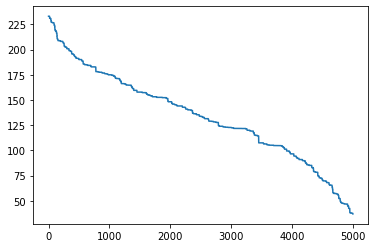

In [15]:
hill_df, best_solution = random_start_hillclimber(best_solution, all_households, rel_poi_df, df_afstandn2)